In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, GRU, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot



In [14]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [15]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [16]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [17]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [18]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [19]:

trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [20]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [21]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [22]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

# GRU1

In [23]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 256)               106752    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 140422 (548.52 KB)
Trainable params: 140422 (548.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 9s 30ms/step - loss: 1.2332 - accuracy: 0.4842 - val_loss: 1.0189 - val_accuracy: 0.5929
Epoch 2/10
58/58 [==============================] - 1s 16ms/step - loss: 0.8793 - accuracy: 0.6496 - val_loss: 0.7996 - val_accuracy: 0.6936
Epoch 3/10
58/58 [==============================] - 1s 16ms/step - loss: 0.5722 - accuracy: 0.7697 - val_loss: 0.5339 - val_accuracy: 0.7892
Epoch 4/10
58/58 [==============================] - 1s 16ms/step - loss: 0.3594 - accuracy: 0.8672 - val_loss: 0.2660 - val_accuracy: 0.9030
Epoch 5/10
58/58 [==============================] - 1s 16ms/step - loss: 0.2221 - accuracy: 0.9149 - val_loss: 0.2103 - val_accuracy: 0.9130
Epoch 6/10
58/58 [==============================] - 1s 16ms/step - loss: 0.1745 - accuracy: 0.9304 - val_loss: 0.1720 - val_accuracy: 0.9261
Epoch 7/10
58/58 [==============================] - 1s 16ms/step - loss: 0.1543 - accuracy: 0.9363 - val_loss: 0.1341 - val_accuracy: 0.9542
Epoch 8/10
58

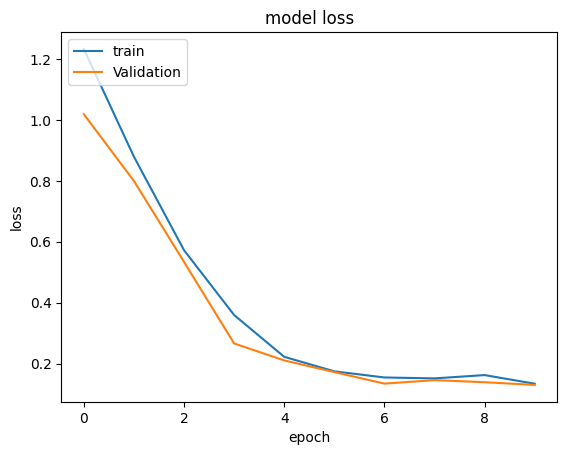

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

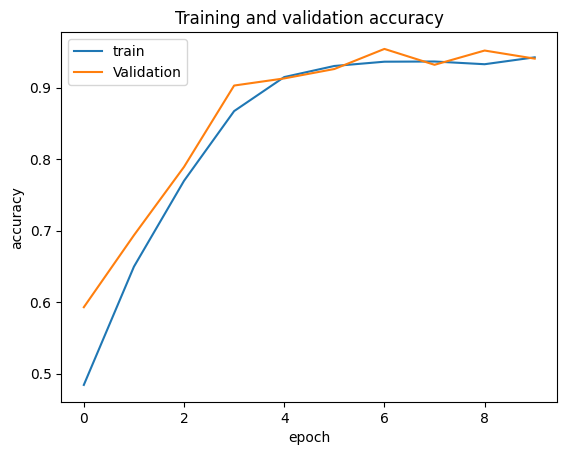

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 1s 6ms/step
[[488   2   6   0   0   0]
 [ 32 421  18   0   0   0]
 [  1   0 417   2   0   0]
 [  0   2   0 366 123   0]
 [  1  10   0  49 472   0]
 [  0   5   0   0   0 532]]
0.9148286392941974
0.9140220688599088
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       496
           1       0.96      0.89      0.92       471
           2       0.95      0.99      0.97       420
           3       0.88      0.75      0.81       491
           4       0.79      0.89      0.84       532
           5       1.00      0.99      1.00       537

    accuracy                           0.91      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.91      0.91      2947



<Axes: >

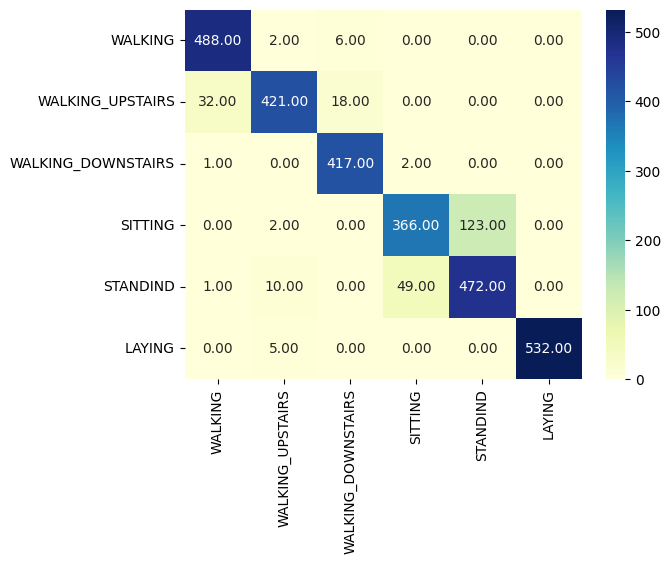

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 2


In [28]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                

In [29]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 11s 57ms/step - loss: 1.1574 - accuracy: 0.5192 - val_loss: 0.9600 - val_accuracy: 0.6102
Epoch 2/10
58/58 [==============================] - 2s 35ms/step - loss: 0.7154 - accuracy: 0.6974 - val_loss: 0.4807 - val_accuracy: 0.8132
Epoch 3/10
58/58 [==============================] - 2s 37ms/step - loss: 0.3059 - accuracy: 0.8860 - val_loss: 0.1874 - val_accuracy: 0.9202
Epoch 4/10
58/58 [==============================] - 2s 37ms/step - loss: 0.1582 - accuracy: 0.9339 - val_loss: 0.1246 - val_accuracy: 0.9547
Epoch 5/10
58/58 [==============================] - 4s 75ms/step - loss: 0.1322 - accuracy: 0.9459 - val_loss: 0.1660 - val_accuracy: 0.9261
Epoch 6/10
58/58 [==============================] - 2s 42ms/step - loss: 0.1454 - accuracy: 0.9396 - val_loss: 0.1221 - val_accuracy: 0.9560
Epoch 7/10
58/58 [==============================] - 2s 39ms/step - loss: 0.1340 - accuracy: 0.9448 - val_loss: 0.1252 - val_accuracy: 0.9438
Epoch 8/10
5

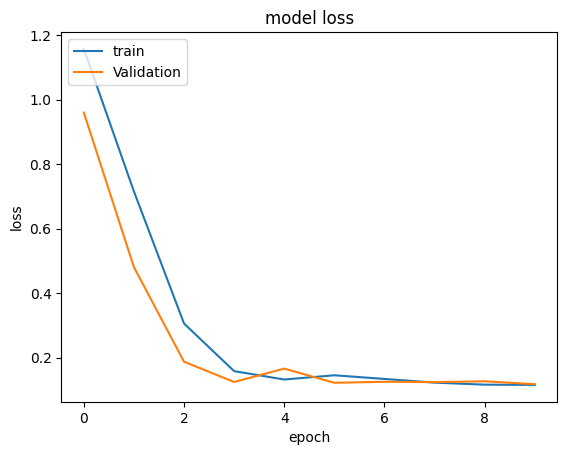

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

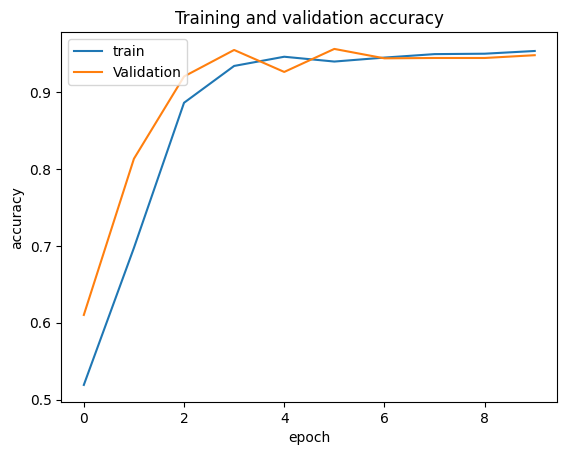

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 9ms/step
[[464   0  31   1   0   0]
 [  1 439  31   0   0   0]
 [  0   1 419   0   0   0]
 [  0  23   0 372  96   0]
 [  1   0   0  58 473   0]
 [  0   1   0   0   0 536]]
0.9172039362063115
0.9165936014126168
              precision    recall  f1-score   support

           0       1.00      0.94      0.96       496
           1       0.95      0.93      0.94       471
           2       0.87      1.00      0.93       420
           3       0.86      0.76      0.81       491
           4       0.83      0.89      0.86       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

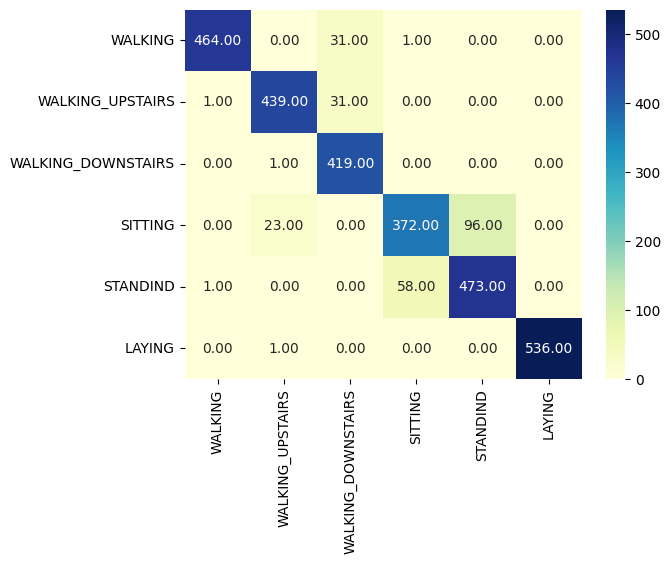

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 3

In [33]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                      

In [34]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 16s 90ms/step - loss: 1.1330 - accuracy: 0.5136 - val_loss: 0.9470 - val_accuracy: 0.6029
Epoch 2/10
58/58 [==============================] - 4s 61ms/step - loss: 0.7121 - accuracy: 0.6941 - val_loss: 0.4676 - val_accuracy: 0.8132
Epoch 3/10
58/58 [==============================] - 4s 61ms/step - loss: 0.3393 - accuracy: 0.8681 - val_loss: 0.2307 - val_accuracy: 0.9093
Epoch 4/10
58/58 [==============================] - 3s 59ms/step - loss: 0.1854 - accuracy: 0.9313 - val_loss: 0.1793 - val_accuracy: 0.9243
Epoch 5/10
58/58 [==============================] - 3s 57ms/step - loss: 0.1544 - accuracy: 0.9376 - val_loss: 0.1562 - val_accuracy: 0.9325
Epoch 6/10
58/58 [==============================] - 3s 56ms/step - loss: 0.1332 - accuracy: 0.9456 - val_loss: 0.1493 - val_accuracy: 0.9347
Epoch 7/10
58/58 [==============================] - 4s 62ms/step - loss: 0.1252 - accuracy: 0.9498 - val_loss: 0.1342 - val_accuracy: 0.9538
Epoch 8/10
5

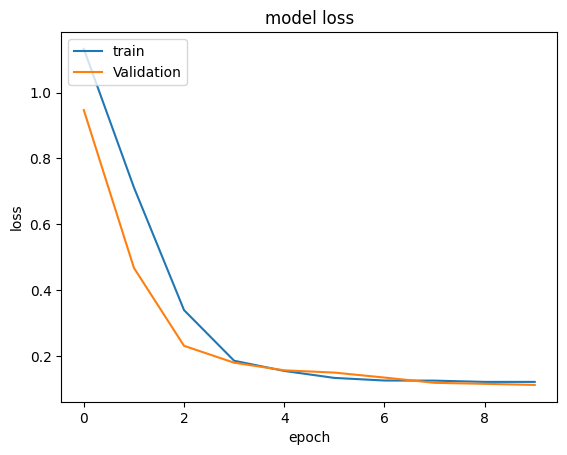

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

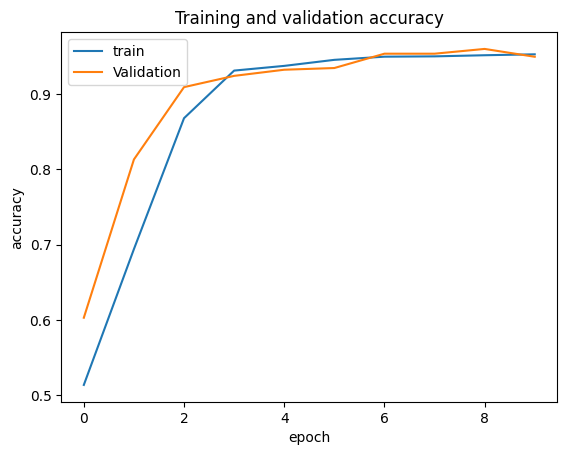

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 15ms/step
[[469   1  25   1   0   0]
 [ 36 409  25   0   1   0]
 [  7  10 403   0   0   0]
 [  0   5   0 382 104   0]
 [  1   0   0  72 459   0]
 [  0  27   0   0   0 510]]
0.8931116389548693
0.8929661097414128
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       496
           1       0.90      0.87      0.89       471
           2       0.89      0.96      0.92       420
           3       0.84      0.78      0.81       491
           4       0.81      0.86      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

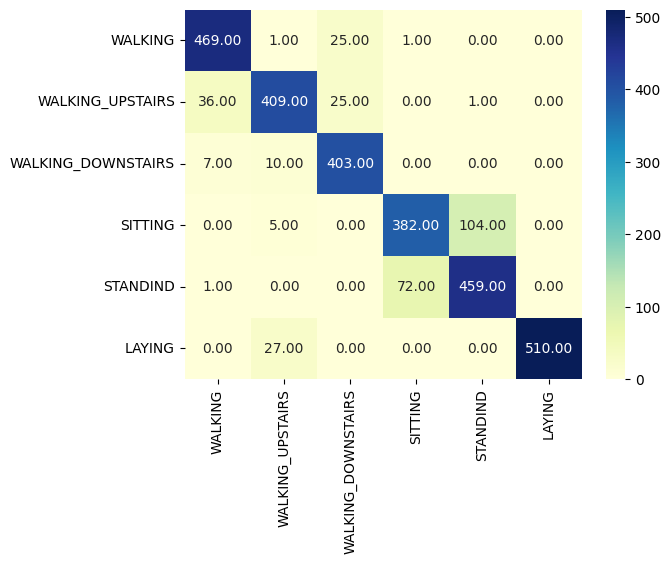

In [37]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU 4

In [38]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 128, 256)          106752    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128, 256)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 128, 256)          296448    
 onal)                                                           
                                                      

In [39]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 21s 119ms/step - loss: 1.1501 - accuracy: 0.5014 - val_loss: 0.9498 - val_accuracy: 0.6219
Epoch 2/10
58/58 [==============================] - 5s 80ms/step - loss: 0.7447 - accuracy: 0.6721 - val_loss: 0.5426 - val_accuracy: 0.7656
Epoch 3/10
58/58 [==============================] - 5s 81ms/step - loss: 0.3645 - accuracy: 0.8580 - val_loss: 0.1851 - val_accuracy: 0.9261
Epoch 4/10
58/58 [==============================] - 5s 79ms/step - loss: 0.1735 - accuracy: 0.9305 - val_loss: 0.1401 - val_accuracy: 0.9329
Epoch 5/10
58/58 [==============================] - 5s 81ms/step - loss: 0.1479 - accuracy: 0.9430 - val_loss: 0.1287 - val_accuracy: 0.9383
Epoch 6/10
58/58 [==============================] - 5s 83ms/step - loss: 0.1350 - accuracy: 0.9457 - val_loss: 0.1209 - val_accuracy: 0.9442
Epoch 7/10
58/58 [==============================] - 5s 81ms/step - loss: 0.1277 - accuracy: 0.9474 - val_loss: 0.1150 - val_accuracy: 0.9479
Epoch 8/10


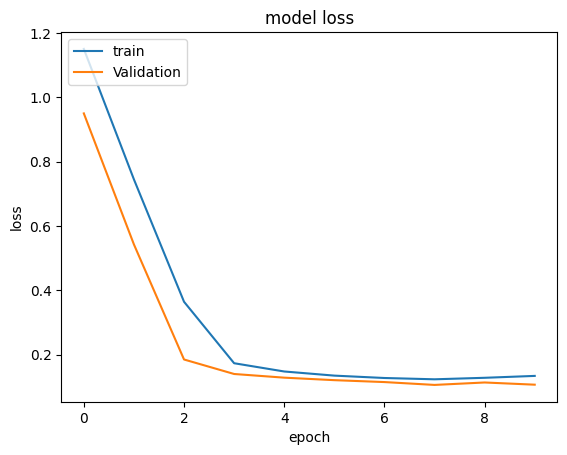

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

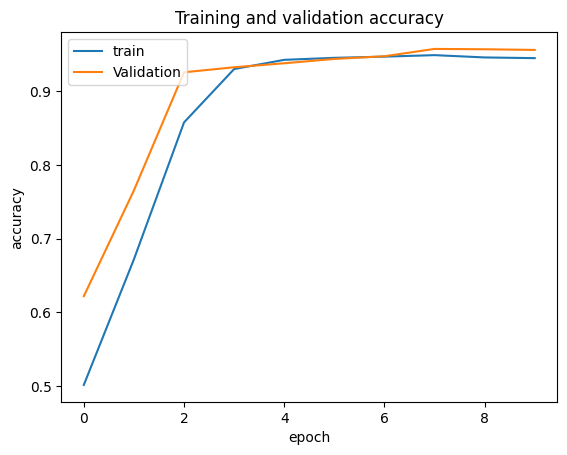

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 5s 18ms/step
[[467   1  28   0   0   0]
 [ 20 434  17   0   0   0]
 [  2   0 418   0   0   0]
 [  0  24   0 385  80   2]
 [  3   0   0  66 463   0]
 [  0  16   0   0   0 521]]
0.9121140142517815
0.9115003869082552
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       496
           1       0.91      0.92      0.92       471
           2       0.90      1.00      0.95       420
           3       0.85      0.78      0.82       491
           4       0.85      0.87      0.86       532
           5       1.00      0.97      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

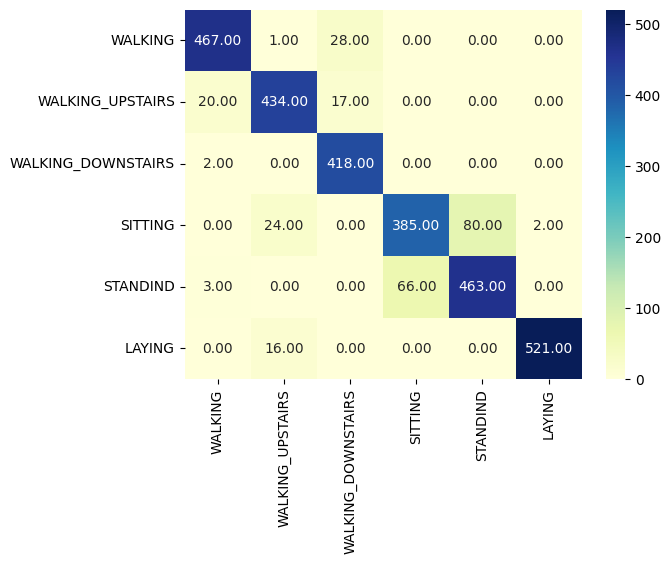

In [42]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# GRU5

In [43]:
# Model 1
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Build and initialize the model before calling summary
model.build(input_shape=(None, n_timesteps,n_features))

# Display model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 128, 256)          106752    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_11 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                                 
 dropout_11 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_12 (Bidirect  (None, 128, 256)          296448    
 ional)                                                          
                                                      

In [44]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)


Epoch 1/10
58/58 [==============================] - 26s 189ms/step - loss: 1.1610 - accuracy: 0.4978 - val_loss: 0.9674 - val_accuracy: 0.6151
Epoch 2/10
58/58 [==============================] - 6s 100ms/step - loss: 0.7212 - accuracy: 0.6858 - val_loss: 0.5021 - val_accuracy: 0.7724
Epoch 3/10
58/58 [==============================] - 6s 102ms/step - loss: 0.3824 - accuracy: 0.8473 - val_loss: 0.3098 - val_accuracy: 0.8776
Epoch 4/10
58/58 [==============================] - 6s 102ms/step - loss: 0.1930 - accuracy: 0.9261 - val_loss: 0.1393 - val_accuracy: 0.9506
Epoch 5/10
58/58 [==============================] - 6s 102ms/step - loss: 0.1553 - accuracy: 0.9387 - val_loss: 0.1220 - val_accuracy: 0.9556
Epoch 6/10
58/58 [==============================] - 6s 104ms/step - loss: 0.1400 - accuracy: 0.9404 - val_loss: 0.1371 - val_accuracy: 0.9374
Epoch 7/10
58/58 [==============================] - 6s 102ms/step - loss: 0.1343 - accuracy: 0.9490 - val_loss: 0.1648 - val_accuracy: 0.9297
Epoch

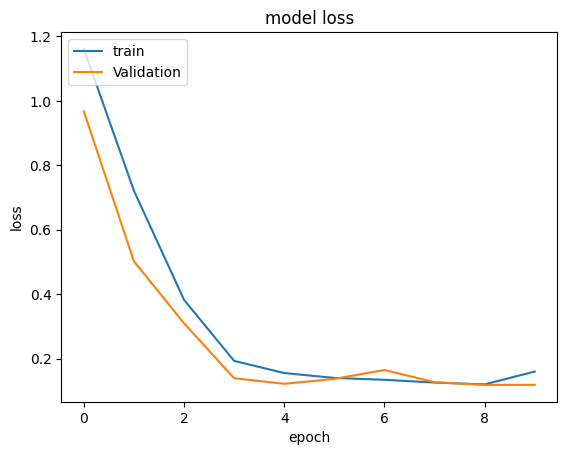

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

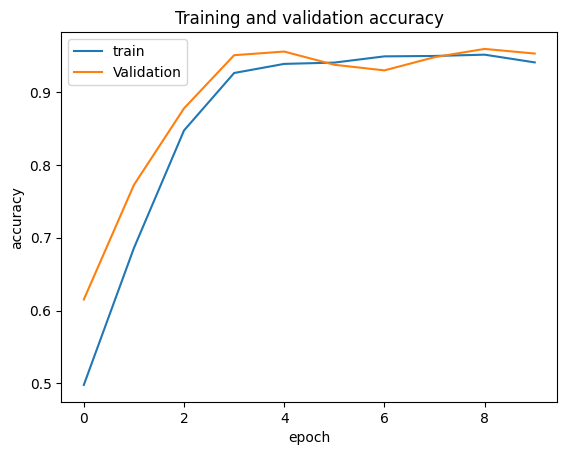

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 20ms/step
[[483   1   8   3   1   0]
 [ 23 425  13   2   6   2]
 [ 32   1 387   0   0   0]
 [  0  17   0 404  62   8]
 [  0   1   0  80 451   0]
 [  0   0   0   0   0 537]]
0.9117746861214795
0.9114584868904249
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       496
           1       0.96      0.90      0.93       471
           2       0.95      0.92      0.93       420
           3       0.83      0.82      0.82       491
           4       0.87      0.85      0.86       532
           5       0.98      1.00      0.99       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

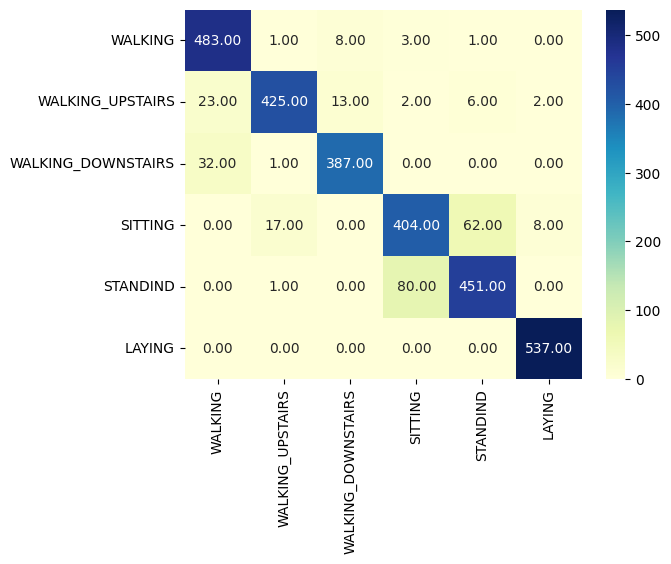

In [47]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')